## Задание
### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

### 2. Оцените ошибку модели из п.1 .

### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [72]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'C:\Work\Python\my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [73]:
data.drop(['Time','year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek','hour','is_holiday','is_next_holiday','is_prev_holiday'], axis = 1, inplace = True)

In [74]:
data.head()

,PJME_MW
Date,
2002-01-01,30393.0
2002-01-01,29265.0
2002-01-01,28357.0
2002-01-01,27899.0
2002-01-01,28057.0


In [75]:
data_m = data.resample('W').mean()

In [76]:
data_m.head()

,PJME_MW
Date,
2002-01-06,32392.160839
2002-01-13,31487.386905
2002-01-20,31452.880952
2002-01-27,30141.529762
2002-02-03,29196.488095


In [77]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [79]:
df = pd.DataFrame(data_m)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)
df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)
df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:,0].values-df.iloc[:-1,0].values


df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,PJME_MW,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,0.000000
2002-01-13,31487.386905,32392.160839,0.000000,0.000000,32383.113100,32365.017621,32319.778924,-904.773934
2002-01-20,31452.880952,31487.386905,32392.160839,0.000000,32373.810778,32337.653521,32250.427087,-34.505952
2002-01-27,30141.529762,31452.880952,31487.386905,32392.160839,32351.487968,32271.769808,32081.715301,-1311.351190
2002-02-03,29196.488095,30141.529762,31452.880952,31487.386905,32319.937969,32179.511357,31850.897124,-945.041667


In [80]:
df.columns

Index(['PJME_MW', 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08',
       'diff1'],
      dtype='object')

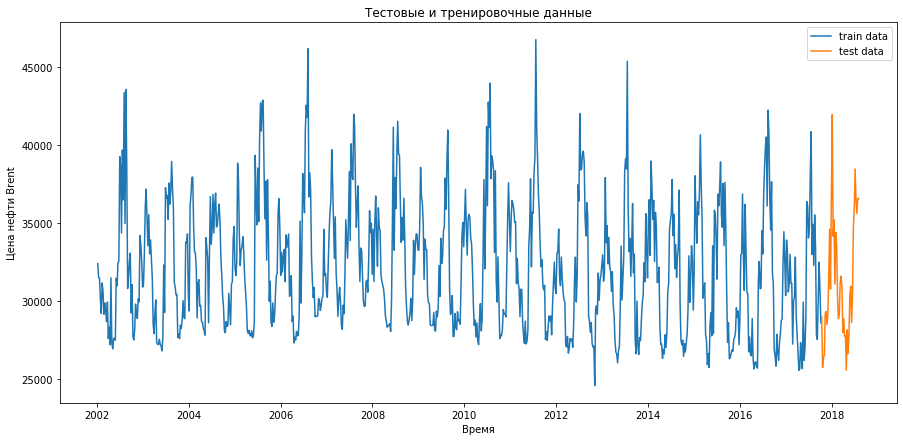

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV


# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()
h = 1
train_b, test_b = split_data_b( df, '10-12-2017')

X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[5]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[5]].values[h:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index,train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index, test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9966421765399988
{'max_depth': 3, 'n_estimators': 100}


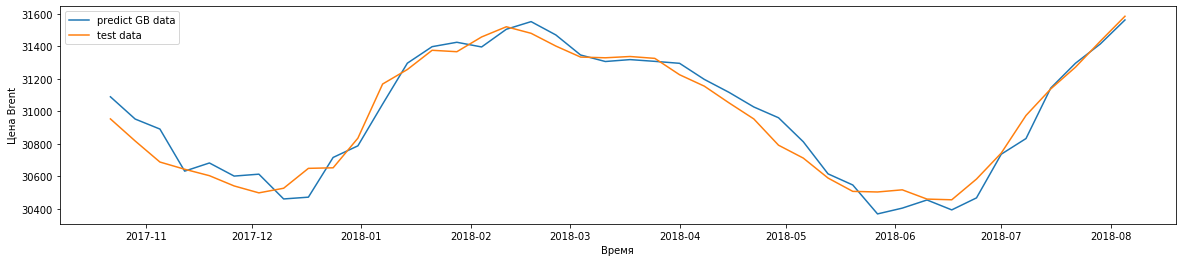

ошибка градиентного бустинга :   0.220917800810318 %


In [82]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

parameters = {
    "max_depth":[3,5,8,15,50],
    "n_estimators":[10, 20, 50, 100, 500]
    }
model_gb = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1)
model_gb.fit(X_train_b, y_train_b)
print(model_gb.score(X_train_b, y_train_b))
print(model_gb.best_params_)

#model_gb.fit(X_train_b, y_train_b) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
#plt.plot(b_s.loc['2018-10-11':].index, b_s.loc['2018-10-11':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Ошибка вполне неплохая.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


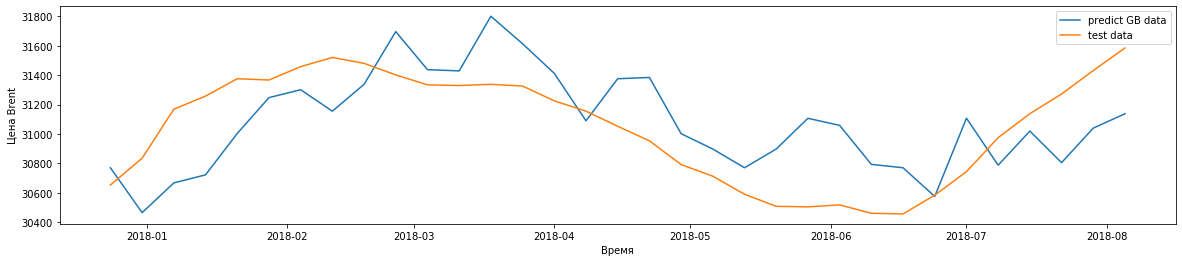

ошибка градиентного бустинга :   0.9457558655931236 %


In [83]:
h = 10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[5]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[5]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
#plt.plot(b_s.loc['2018-10-11':].index, b_s.loc['2018-10-11':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

При увеличении горизонта прогноза на 10 дней, ошибка цвеличилась примерно в 4 раза

### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном: Если горизонт год, то стационарный, без тренда сезонный и с циклом.

б) Количество денег, которые тратят покупатели в интернет магазине: не стационарный, с трендом, сезонность и циклами.

в) Вес растущего котенка: не стационарный, с трендом, возможно с небольшими сезонными колебаниями

г) Прирост объема деревьев в лесу от времени: не стационарный, с трендом, с сезонностью 

http://dendrology.ru/books/item/f00/s00/z0000042/st024.shtml

### 5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

B D G

Интересные ссылки:
1. Пакет стат.моделирования https://www.statsmodels.org/stable/
1. Пакет для прогнозирования во временных рядах от FaceBook https://facebook.github.io/prophet/docs/quick_start.html